# Данные

In [43]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


corp_col = '#40ba21'

df = pd.read_csv("Never Trust Summary Statistics.tsv", delimiter="\t")
df["dataset"].unique()

array(['dino', 'away', 'h_lines', 'v_lines', 'x_shape', 'star',
       'high_lines', 'dots', 'circle', 'bullseye', 'slant_up',
       'slant_down', 'wide_lines'], dtype=object)

## Выберем в качестве бинарной переменной колонку dataset, присвоив 1 фигуре "wide_lines", остальным 0, то есть задача будет сводится к определению относится ли конкретная точка в массиве к фигуре "wide_lines" или нет.

In [44]:
df.loc[df["dataset"] != 'wide_lines', "dataset"] = 0
df.loc[df["dataset"] == 'wide_lines', "dataset"] = 1
df["dataset"] = df["dataset"].astype(int)

In [45]:
df

,dataset,x,y
0,0,55.384600,97.179500
1,0,51.538500,96.025600
2,0,46.153800,94.487200
3,0,42.820500,91.410300
4,0,40.769200,88.333300
...,...,...,...
1841,1,33.674442,26.090490
1842,1,75.627255,37.128752
1843,1,40.610125,89.136240
1844,1,39.114366,96.481751


# Домашнее задание 6

## Обучающая и тестовая выборки.

In [46]:
from sklearn.model_selection import train_test_split

X = df.drop(['dataset'], axis=1) # X — признаки (features)
y = df[['dataset']]              # y — целевая переменная (label)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,x,y
1578,35.435533,34.961038
590,57.134855,53.877966
952,64.067096,27.776501
1138,51.288459,82.435940
1461,47.225025,44.575647
...,...,...
1130,50.378262,16.946280
1294,36.894328,47.706556
860,25.985500,74.349388
1459,33.167757,31.247741


## Оценка параметров логистической регрессии

Так как объясняющие переменные это координаты и они в одном масштабе, то нет смысла использовать стандартизацию переменных.

In [47]:
from sklearn.linear_model import LogisticRegression

# Создание объекта логистической регрессии
log_reg = LogisticRegression(max_iter=1000)

# Обучение модели на подготовленных тренировочных данных
log_reg.fit(X_train, y_train)

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

## Предсказание

In [49]:
# Прогнозирование классов на тестовом наборе
probs = log_reg.predict_proba(X_test)[:, 1]
predictions = log_reg.predict(X_test)

## График Recall-Precision

Этот график особенно полезен, когда в данных наблюдается значительный дисбаланс классов (мало положительных примеров по сравнению с отрицательными). В нашем случае таких примерно 8% (то 8% точек относятся к фигуре "wide_lines").

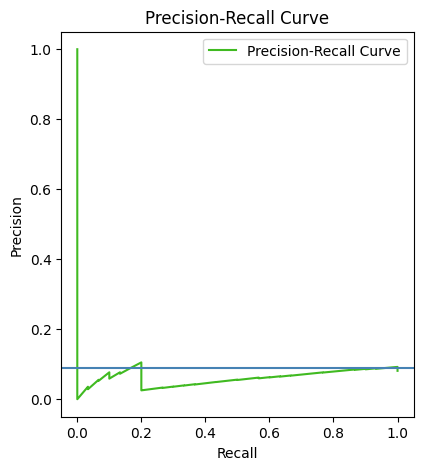

In [51]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Строим график Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, color=corp_col, label="Precision-Recall Curve")
plt.axhline( y = y_test.loc[y_test["dataset"] > 0].count().values[0]  / y_test.loc[y_test["dataset"] == 0].count().values[0], color='steelblue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")


### Базовая линия -- горизонтальная прямую на уровне доли положительных примеров во всей выборке (8% точек относятся к фигуре "wide_lines"). Эта линия служит ориентиром, показывая, какой бы была точность модели, если бы она случайно назначала выбирала класс с вероятностью равной доле положительных примеров в наборе данных. Поэтому результаты точности на уровне или ниже базовой линии является показателем случайности выбора класса, то есть неработоспособности модели для данной задачи, что мы и наблюдаем на графике.

In [52]:
min(thresholds), max(thresholds)

(np.float64(0.05859499854347358), np.float64(0.09362667783089636))

#### Уровень вероятности отсечки классов для модели по результатам построяения графика тоже в районе 8%.

In [53]:
y_train["dataset"].count()

np.int64(1476)

## График ROC

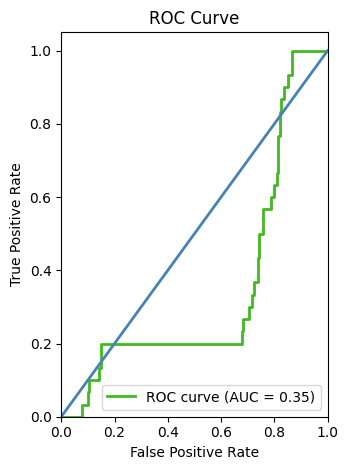

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color=corp_col, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='steelblue', lw=2)  # Диагональная линия
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Интерпретация метрики AUC-ROC (Area Under Curve):

    1. AUC = 0.5 → случайное угадывание.
    2. AUC > 0.85 → хорошая модель.
    3. AUC = 1.0 → идеальное разделение.

#### В нашем случае показатель AUC-ROC также показывает на случайное угадывание. 

## Матрица ошибок

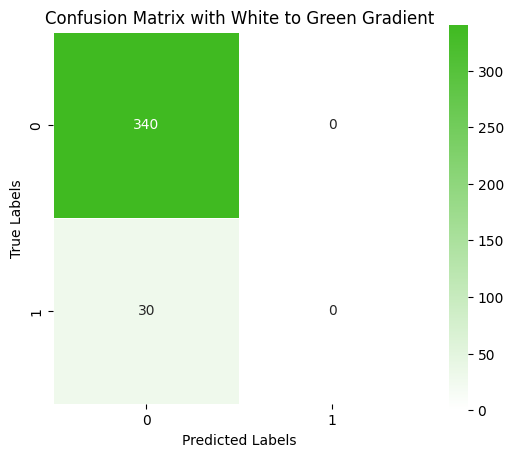

In [55]:
# Рассчитываем матрицу ошибок
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Матрица ошибок
cm = confusion_matrix(y_test, predictions)

# Исходный зеленый цвет в HEX
hex_green_color = corp_col

# Преобразуем hex-код в tuple (R,G,B)
rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

# Создаем градиент от белого (1,1,1) до нашего зеленого цвета
colors = [(1, 1, 1), rgb_green_color]

# Создаем линейную сегментированную цветовую карту
c_map = LinearSegmentedColormap.from_list("", colors)

# Строим матрицу ошибок с градиентом цветов
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with White to Green Gradient")
plt.show()

### При стандартном пороге вероятности 0.5, модель ни разу не спрогнозировала 1, с учетом дисбаланса в выборке понизим порог!

## Применяем новую классификацию с другим порогом

### Попробуем циклом пройтись по значениям порога и выбрать такой, при котором будет максимальный f1-score.

In [61]:
from sklearn.metrics import f1_score

best_threshold = 0
best_f1 = 0
for threshold in np.linspace(0.01, 0.5, 50):
    y_pred = (probs >= threshold).astype(int)
    score = f1_score(y_test, y_pred)
    print("F1-score при пороге {:.2f}: {:.4f}".format(threshold, score), end="\r")
    if score > best_f1:
        best_f1 = score
        best_threshold = threshold
        
print(best_threshold)

0.0600000000000000050.50: 0.0000


### Оптимальное значение порога 0.06

In [62]:
# Применяем новую классификацию с другим порогом
predictions2 = (probs >= 0.06).astype(int)

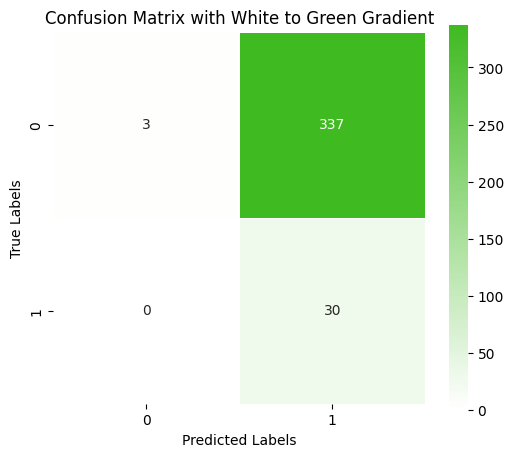

In [63]:
# Матрица ошибок
cm = confusion_matrix(y_test, predictions2)

# Исходный зеленый цвет в HEX
hex_green_color = corp_col

# Преобразуем hex-код в tuple (R,G,B)
rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

# Создаем градиент от белого (1,1,1) до нашего зеленого цвета
colors = [(1, 1, 1), rgb_green_color]

# Создаем линейную сегментированную цветовую карту
c_map = LinearSegmentedColormap.from_list("", colors)

# Строим матрицу ошибок с градиентом цветов
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with White to Green Gradient")
plt.show()

### Снижения порога вероятности (threshold) разделения классов, приводит лишь к перетеканию предсказаний из True Negative в False Negative. Модель попрежнему не способна выделить координаты интересующенй нас фигуры (True Positive).

## Метрики качества

In [64]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [65]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

# Ручной расчет метрик
precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)
specificity_manual = TN / (TN + FP)
f1_manual = 2 * ((precision_manual * recall_manual) / (precision_manual + recall_manual))
accuracy_manual = (TP + TN) / (TP + TN + FP + FN)

print("\nМетрики:")
print(f"Прецизионность (Precision): {precision_manual:.3f}")
print(f"Полнота (Recall): {recall_manual:.3f}")
print(f"Специфичность (Specificity): {specificity_manual:.3f}")
print(f"F1-Score: {f1_manual:.3f}")
print(f"Общая точность (Accuracy): {accuracy_manual:.3f}")


Метрики:
Прецизионность (Precision): 0.082
Полнота (Recall): 1.000
Специфичность (Specificity): 0.009
F1-Score: 0.151
Общая точность (Accuracy): 0.089


### Точность по-прежнему на уровне случайности!

# Общие выводы

### Логистическая регрессия на основе координат оказалась неспобна выделить интересующую нас фигуру как на стандартнои пороге 0.5, так и на оптимальной пороге 0.06. Точность оказалась на уровне случайного гадания.

In [69]:
# График разброса
fig = px.scatter(df.loc[ df["dataset"] == 1, :], x='x', y='y', color_discrete_sequence=[corp_col], size_max=10)

# Фон и подписи
fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Вещественная переменная X',
    yaxis_title='Вещественная переменная Y'
)

fig.show()